In [1]:
import pandas as pd

import warnings 
warnings.filterwarnings("ignore")


from tqdm import tqdm_notebook

In [16]:
data = pd.read_csv("./data/최종데이터_ESG환산 copy.csv", index_col=0)
LEV = pd.read_csv("./data/LEV.csv", dtype={'종목코드':'str'}, index_col=0)
SIZE = pd.read_csv("./data/SIZE.csv", dtype={'종목코드':'str'}, index_col=0)
OCF = pd.read_csv("./data/OCF_최종.csv", index_col=0, dtype={'stock_code':'str'})
CAPEX = pd.read_csv("./data/CAPEX_최종.csv", index_col=0, dtype={'stock_code':'str'})
corp_code = pd.read_csv("./data/ROA.csv", dtype={'stock_code':'str'})[['stock_code', '종목명']]
corp_code.columns=['종목코드', '종목명']

In [17]:
data = pd.merge(data, corp_code, how='left')[['종목코드', '종목명', '연도', '종합등급', '환경', '사회', '지배구조', 'ROA', 'ROE', 'tobinQ', '누적수익률', '코스피누적수익률']]
data = pd.merge(data, LEV, how='left')
data = pd.merge(data, SIZE, how='left')
data = pd.merge(data, OCF[['종목명', '연도', 'OCF']], on=['종목명', '연도'])
data = pd.merge(data, CAPEX[['종목명', '연도', 'CAPEX']], on=['종목명', '연도'])

In [18]:
import numpy as np
data = data.replace("A+", 6).replace("A", 5).replace("B+", 4).replace("B", 3).replace("C", 2).replace("D", 1).replace("E", np.NaN)

In [19]:
data.dropna(axis=0, inplace=True)

In [20]:
data = data[data['누적수익률'] != 'np.NAN']
data['누적수익률'] = data['누적수익률'].astype('float')

In [112]:
data.join(pd.get_dummies(data['연도']))

0       0
1       0
2       0
3       0
4       0
       ..
3937    0
3938    0
3939    0
3940    0
3941    0
Name: 2012, Length: 3942, dtype: uint8

In [78]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [82]:
## 이상치 제거
def outliers_iqr(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    # 넘파이 값을 퍼센트로 표시해주는 함수
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    return np.where((data > upper_bound) | (data < lower_bound))

In [80]:
data.reset_index(drop=True, inplace=True)

In [85]:
outlier_cols = ['ROA', 'ROE','tobinQ', 'OCF', 'CAPEX']
total_outliers = []
normal_index = []

for col in outlier_cols:
    outliers_index = outliers_iqr(data[col])[0]
    total_outliers.append(outliers_index)

total_outliers = [val for arr in total_outliers for val in arr]
print(len(total_outliers))

for i in data.index:
    if i not in total_outliers:
        normal_index.append(i)

1716


In [88]:
data2 = data.loc[normal_index]

In [114]:
res = ols('ROA ~ 환경+ROE+LEV+SIZE+OCF+CAPEX', data=data2).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     116.5
Date:                Tue, 17 May 2022   Prob (F-statistic):          8.00e-136
Time:                        10:23:51   Log-Likelihood:                 9526.9
No. Observations:                3942   AIC:                        -1.904e+04
Df Residuals:                    3935   BIC:                        -1.900e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1355      0.022      6.105      0.0

In [153]:
res = ols('tobinQ ~ 사회+연도+ROE+LEV+SIZE+OCF+CAPEX+누적수익률', data=data2).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 tobinQ   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     262.6
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        11:11:07   Log-Likelihood:                 7656.4
No. Observations:                3942   AIC:                        -1.529e+04
Df Residuals:                    3933   BIC:                        -1.524e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1336      0.391      5.461      0.0

In [119]:
X = data[['환경', 'LEV', 'SIZE', 'ROE', 'OCF', 'CAPEX', '누적수익률']].join(pd.get_dummies(data['연도']))
y = data['tobinQ']
results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 tobinQ   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     113.1
Date:                Tue, 17 May 2022   Prob (F-statistic):          1.48e-323
Time:                        10:34:06   Log-Likelihood:                -51262.
No. Observations:                3942   AIC:                         1.026e+05
Df Residuals:                    3924   BIC:                         1.027e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.239e+05   2.42e+04     33.999      0.000    7.76e+05    8.71e+05
환경          3.007e+04   1850.820     16.244      0.000    2.64e+04    3.37e+04
LEV         5.801e+04   8577.454      6.763      0.000    4.12e+04    7.48e+04
SIZE       -3.693e+04   1034.648    -35.697      0.000    -3.9e+04   -3.49e+04
ROE           -1.8710      7.482     -0.250      0.803     -16.540      12.799
OCF         2.258e+05   2.59e+04      8.704      0.000    1.75e+05    2.77e+05
CAPEX       -238.6577     18.933    -12.605      0.000    -275.778    -201.538
누적수익률        -66.5328     26.451     -2.515      0.012    -118.392     -14.674
2011        1.273e+05   8519.425     14.941      0.000    1.11e+05    1.44e+05
2012        1.002e+05   6842.803     14.646      0.000    8.68e+04    1.14e+05
2013        5.865e+04   5984.872      9.800      0.000    4.69e+04    7.04e+04
2014        6.014e+04   5929.686     10.142      0.000    4.85e+04    7.18e+04
2015        6.711e+04   5938.235     11.302      0.000    5.55e+04    7.88e+04
2016        6.321e+04   5739.908     11.013      0.000     5.2e+04    7.45e+04
2017         5.83e+04   5681.115     10.263      0.000    4.72e+04    6.94e+04
2018        6.354e+04   5648.585     11.248      0.000    5.25e+04    7.46e+04
2019        7.494e+04   5725.125     13.089      0.000    6.37e+04    8.62e+04
2020        7.276e+04   5746.516     12.661      0.000    6.15e+04     8.4e+04
2021        7.771e+04   5832.463     13.324      0.000    6.63e+04    8.91e+04
==============================================================================
Omnibus:                     6901.476   Durbin-Watson:                   1.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8151881.689
Skew:                          12.232   Prob(JB):                         0.00
Kurtosis:                     224.433   Cond. No.                     2.08e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.8e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 분산분석

In [155]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('tobinQ ~ 종합등급', data).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
종합등급,1.0,9.022847e+11,9.022847e+11,53.096479,3.816877e-13
Residual,3940.0,6.695362e+13,1.699331e+10,NaN,NaN


In [156]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

hsd = pairwise_tukeyhsd(data['tobinQ'], data['종합등급'], alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1.0,2.0,25.0169,1.0,-69099.0354,69149.0693,False
1.0,3.0,4323.2534,1.0,-62623.9157,71270.4226,False
1.0,4.0,9002.5697,0.999,-59354.2332,77359.3726,False
1.0,5.0,64873.1929,0.0873,-5091.7733,134838.159,False
1.0,6.0,114672.2155,0.0062,21287.0007,208057.4302,True
2.0,3.0,4298.2365,0.9902,-15722.6118,24319.0848,False
2.0,4.0,8977.5527,0.8999,-15344.5239,33299.6293,False
2.0,5.0,64848.1759,0.0,36317.3611,93378.9908,True
2.0,6.0,114647.1986,0.0,46531.7874,182762.6098,True
3.0,4.0,4679.3162,0.9715,-12506.4993,21865.1318,False


# 시각화

In [136]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

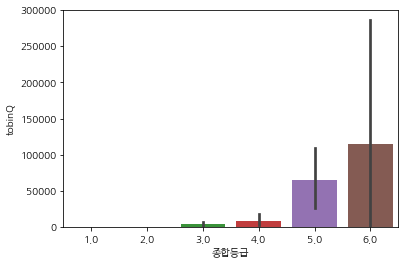

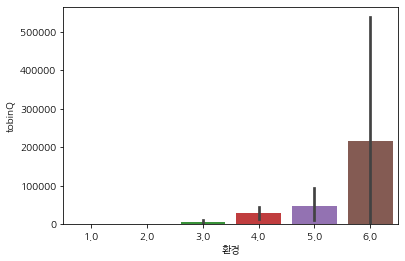

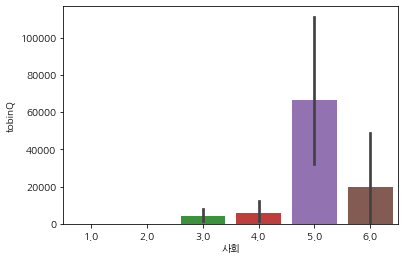

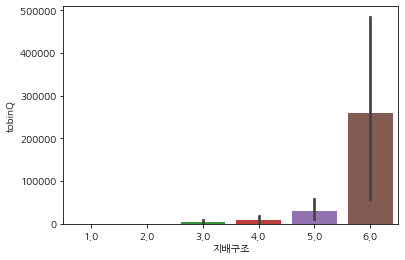

In [150]:
group = ['종합등급', '환경', '사회', '지배구조']
for g in group:
    sns.barplot(data=data, x=g, y='tobinQ', estimator=np.mean)
    plt.show()

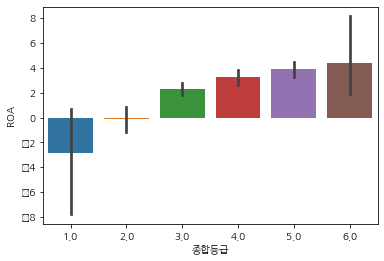

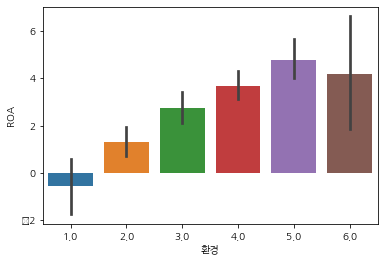

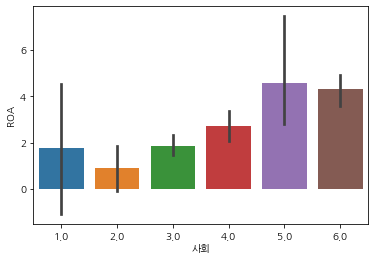

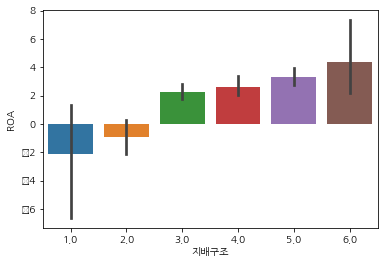

In [151]:
group = ['종합등급', '환경', '사회', '지배구조']
for g in group:
    sns.barplot(data=data, x=g, y='ROA', estimator=np.mean)
    plt.show()

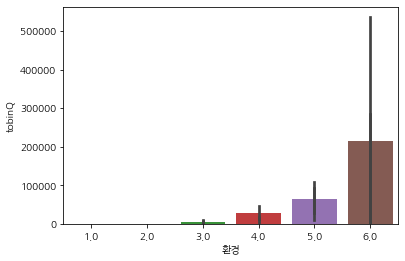

In [149]:
import matplotlib.pyplot as plt

fig = plt.figure()
sns.barplot(data=data, x='종합등급', y='tobinQ', estimator=np.mean)
plt.show()

sns.barplot(data=data, x='환경', y='tobinQ', estimator=np.mean)
plt.show()